In [5]:
!pip install gdown
!pip install gensim

In [6]:
!gdown https://drive.google.com/uc?id=1TQv6oGf3uySrXGkB4iT__4wgycVadH8F
!gdown https://drive.google.com/uc?id=12-zJnHZaRNlHweeBOk0t2yHbkyvFRsf1
#Get pretrained word2vec vectors - this file size is 1.5GB, it will take time
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

Downloading...
From: https://drive.google.com/uc?id=1TQv6oGf3uySrXGkB4iT__4wgycVadH8F
To: /content/train.csv
3.96MB [00:00, 61.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=12-zJnHZaRNlHweeBOk0t2yHbkyvFRsf1
To: /content/test.csv
100% 1.09M/1.09M [00:00<00:00, 71.3MB/s]
--2020-11-14 18:52:59--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.45.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.45.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  73.6MB/s    in 22s     

2020-11-14 18:53:21 (71.8 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#some libraries cause this future warnings when the newer versions will be released. To prevent showing them, this code is used.

# WORD2VEC OVERVIEW

In [8]:
from gensim.models import KeyedVectors

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

All word vectors are 300 dimensional dense vectors. 

In [9]:
word2vec["google"].shape

(300,)

Thanks to these dense vectors, semantic and syntactic similarities can be captured between the words because the similar word vectors are closer to each other in the 300-d vector space compared to different words

In [10]:
word2vec.most_similar("cat",topn=3) #top 3 similar word for cat: as seen, cats (syntactic similarity) and dog & kitten (semantic similarity)

[('cats', 0.8099379539489746),
 ('dog', 0.7609456777572632),
 ('kitten', 0.7464985251426697)]

In [11]:
word2vec.most_similar("france",topn=3)

[('spain', 0.6375303268432617),
 ('french', 0.6326056718826294),
 ('germany', 0.6314354538917542)]

By utilizing this relationships, it is possible to create both syntactic and semantic analogies.

In [12]:
def analogy(x1, x2, y1):
    result = word2vec.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [13]:
#semantic analogies
analogy('turkey', 'turkish', 'japan')

'japanese'

In [14]:
#syntactic analogies
analogy('good', 'best', 'long')

'longest'

Let's see the words and their positions in the 2-dimensional vector space by using dimension reduction techniques (PCA)!

In [15]:
import numpy as np
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def display_pca_scatterplot(model, words):
       
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(8,8))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.show()


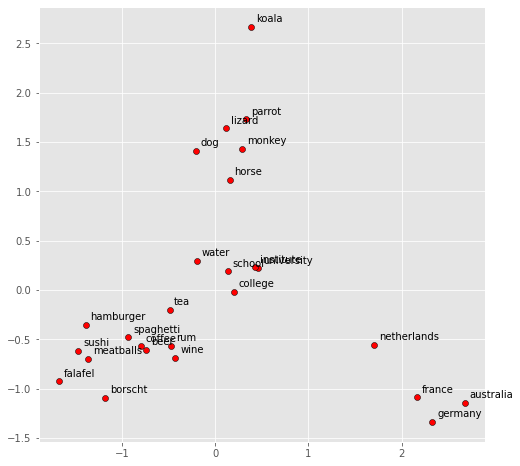

In [16]:
words=['coffee', 'tea', 'beer', 'wine', 'rum', 'water',
      'spaghetti', 'borscht', 'hamburger', 'falafel', 'sushi', 'meatballs',
      'dog', 'horse', 'monkey', 'parrot', 'koala', 'lizard',
      'france', 'germany', 'netherlands', 'australia',
      'school', 'college', 'university', 'institute']
display_pca_scatterplot(word2vec,words)

#  AMAZON MUSIC INSTRUMENTS - REVEWS AND RATINGS DATASET

Original Amazon Musical Instruments dataset contains around 230K reviews and ratings. However, training the model with this amount takes a lot of time. Therefore, we previously prepare the data as highly balanced and smaller size. The reason for that **handling imbalanced data is advanced topic, if you are interestedn in this, [you can follow this paper.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5128907)** The script includes data preparation steps will be shared with participants after the workshop.

In [70]:
import pandas as pd
df_train = pd.read_csv(r"train.csv",index_col=[0])
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print()
print(df_train["label"].value_counts())
df_test = pd.read_csv(r"test.csv",index_col=[0])
# Report the number of sentences.
print()
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))
print()
print(df_test["label"].value_counts())

Number of training sentences: 10,500


2    3500
1    3500
0    3500
Name: label, dtype: int64

Number of test sentences: 3,000


1    1000
2    1000
0    1000
Name: label, dtype: int64


**Classes:**



0.   Negative
1.   Neutral
2.   Positive


In [71]:
df_train.head()

,review,label
0,I'm giving two stars simply because the capo d...,0
1,"Yes, it is possible to tell the difference bet...",0
2,Far too slippery for my fingers when I shreddi...,0
3,"I tried to ignore the other reviews, but I had...",0
4,I bought a set of 3 regular light gauge (.10) ...,0


In [72]:
df_test.head()

,review,label
0,This is one of the worst reverb pedals I have ...,0
1,I really like this at first. The ability to o...,0
2,This is an update to my original review becaus...,0
3,"It's OK. But if you try to raise the height, t...",0
4,"Loved the reviews, just wish it would have wor...",0


## TEXT PREPROCESSING

In [73]:
 df_train.review[100]

'I ordered two of these cables in April.  Today, on September 30, both are not operational.  PVC for connectors is a dumb idea.  Both cables have issues with the straight connector, if I move and hold the connector in an offset position, I can get a signal from the amp.  Other than that, no connection at all.  These cables were a total waste of money.  The 30 day return policy is BS.  I should be entitled to a refund.  Amazon should take responsibility because I bought the cable because touted these "best seller,".  Bestseller or not, these cables are cheap pieces of garbage.'

In [74]:
import numpy as np 
import nltk
import string as s
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer=nltk.stem.WordNetLemmatizer()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix,classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

In [75]:
def preprocess(text,remove_stop_punc=False):
  text=text.lower()
  
  text=text.replace("\n"," ")
  #removing URL
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)

  #Replace &amp, &lt, &gt with &,<,> respectively
  text=text.replace(r'&amp;?',r'and')
  text=text.replace(r'&lt;',r'<')
  text=text.replace(r'&gt;',r'>')

  #remove hashtags
  text=re.sub(r"#[A-Za-z0-9]+","",text)   
  #remove \
  text=re.sub(r"\\ "," ",text)
 
  #remove punctuations and stop words
  stop_words=stopwords.words('english')
  tokens=nltk.word_tokenize(text)
  if remove_stop_punc:
    tokens_new=[i for i in tokens if not i in stop_words and i.isalpha()] #isalpha() method returns True if all the characters are alphabet letters
  else:
    tokens_new=tokens
  #tokens_new=[lemmatizer.lemmatize(i) for i in tokens_new]

  #remove excess whitespace
  text= ' '.join(tokens_new)
  return text

df_train["review"]=df_train["review"].apply(preprocess,remove_stop_punc=False)
df_test["review"]=df_test["review"].apply(preprocess,remove_stop_punc=False)

#Remove reviews which have no word in them
df_train["Text_length"] = [len(text.split(' ')) for text in df_train.review]
df_train = df_train[df_train["Text_length"]>1]

#Remove reviews which have no word in them
df_test["Text_length"] = [len(text.split(' ')) for text in df_test.review]
df_test = df_test[df_test["Text_length"]>1]


In [76]:
df_train.review[100]

"i ordered two of these cables in april . today , on september 30 , both are not operational . pvc for connectors is a dumb idea . both cables have issues with the straight connector , if i move and hold the connector in an offset position , i can get a signal from the amp . other than that , no connection at all . these cables were a total waste of money . the 30 day return policy is bs . i should be entitled to a refund . amazon should take responsibility because i bought the cable because touted these `` best seller , '' . bestseller or not , these cables are cheap pieces of garbage ."

##### **BEFORE PREPROCESSING:**

> I ordered two of these cables in April.  Today, on September 30, both are not operational.  PVC for connectors is a dumb idea.  Both cables have issues with the straight connector, if I move and hold the connector in an offset position, I can get a signal from the amp.  Other than that, no connection at all.  These cables were a total waste of money.  The 30 day return policy is BS.  I should be entitled to a refund.  Amazon should take responsibility because I bought the cable because touted these "best seller,".  Bestseller or not, these cables are cheap pieces of garbage.

##### **AFTER PREPROCESSING:**

> ordered two cable april today september operational pvc connector dumb idea cable issue straight connector move hold connector offset position get signal amp connection cable total waste money day return policy b entitled refund amazon take responsibility bought cable touted best seller bestseller cable cheap piece garbage



# FEATURE EXTRACTION WITH WORD2VEC

To obtain sentence or news vector representations, the aggregation of word vectors is required. There are lots of approaches in the applications. In this workshop, we will take average of word vectors to represent news. 

Also, in the related function, we add if condition which controls whether the related word exists in vocabular or not because Word2vec may not have all possible word vectors. Therefore, out-of-vocabulary (OOV) problem can occur if words do not exist.

In [77]:
def vocab_control(word):
  if word in word2vec.vocab.keys():
    print("{} exists in the vocabulary".format(word))
  else:
    print("{} does not exist in the vocabulary and it is the example for OOV problem".format(word))

In [78]:
vocab_control("sweden")

sweden exists in the vocabulary


In [79]:
vocab_control("luxemburg")

luxemburg does not exist in the vocabulary and it is the example for OOV problem


In [80]:
from nltk.tokenize import WordPunctTokenizer
WPT = WordPunctTokenizer()

def news_embed(sentence):
    sentence=sentence.lower()
    tokens=WPT.tokenize(sentence)
    new_tokens=[token for token in tokens]

    sent_list=[]
    for word in new_tokens:
        if word in word2vec.vocab.keys():
          wv=word2vec[word]
          sent_list.append(wv)
        else:
          continue
    if len(sent_list)<1:
      dummy=np.random.normal(0.5, 0.5, 300)
      sent_list.append(dummy)
    sent_embed= np.mean(sent_list,axis=0)
    return sent_embed

In [81]:
sentence="Principai offers customized NLP solutions"

In [82]:
a=news_embed(sentence)
a.shape

(300,)

In [83]:
type(a)

numpy.ndarray

In [84]:
texts = df_train.review
labels = df_train.label

from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(texts, labels, random_state=42, test_size=0.2)

test_x=df_test.review
test_y=df_test.label

In [85]:
train_array=np.array([news_embed(news) for news in train_x])
valid_array=np.array([news_embed(news) for news in valid_x])
test_array=np.array([news_embed(news) for news in test_x])
train_array.shape

(8232, 300)

# MODELLING

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). However, **it requires non-negative inputs.** Since w2v vectors may have negative values, we will apply Linear Support Vector Classifier algorith via [sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) library.

In [86]:
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=0)
model.fit(train_array, train_y)
pred=model.predict(valid_array)
from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of W2V and LinearSVC over validation set is:",accuracy_score(valid_y, pred))

print(classification_report(valid_y, pred))


Accuracy of W2V and LinearSVC over validation set is: 0.6428571428571429
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       710
           1       0.56      0.54      0.55       699
           2       0.72      0.71      0.71       649

    accuracy                           0.64      2058
   macro avg       0.64      0.64      0.64      2058
weighted avg       0.64      0.64      0.64      2058



#TESTING THE MODEL

In [87]:
test_pred=model.predict(test_array)

from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of W2V and LinearSVC over test set is:",accuracy_score(test_y, test_pred))

print(classification_report(test_y, test_pred))


Accuracy of W2V and LinearSVC over test set is: 0.6290760869565217
              precision    recall  f1-score   support

           0       0.62      0.67      0.64       994
           1       0.55      0.50      0.53       981
           2       0.71      0.72      0.71       969

    accuracy                           0.63      2944
   macro avg       0.63      0.63      0.63      2944
weighted avg       0.63      0.63      0.63      2944



<Figure size 432x288 with 0 Axes>

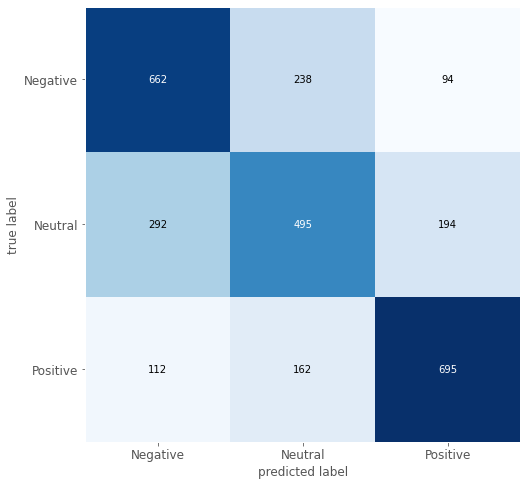

In [88]:
cm  = confusion_matrix(test_y, test_pred)
labels = ['Negative', 'Neutral', 'Positive']
from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(8,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), labels, fontsize=12)
plt.yticks(range(3), labels, fontsize=12)
plt.show()